In [125]:
import glob
import os
import json
import pickle
import yaml

import math
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pyarrow.parquet as pq
from sklearn.metrics import auc, roc_curve
from scipy.special import softmax

import hist as hist2
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.CMS)

import utils
plt.rcParams.update({"font.size": 20})

In [126]:
! ls ../Mar19Inf_2017

DYJetsToLL_Pt-100To250        QCD_Pt_600to800
DYJetsToLL_Pt-250To400        QCD_Pt_800to1000
DYJetsToLL_Pt-400To650        TTTo2L2Nu
DYJetsToLL_Pt-50To100         TTToHadronic
DYJetsToLL_Pt-650ToInf        TTToSemiLeptonic
GluGluHToWW_Pt-200ToInf_M-125 WJetsToLNu_HT-100To200
QCD_Pt_1000to1400             WJetsToLNu_HT-1200To2500
QCD_Pt_1400to1800             WJetsToLNu_HT-200To400
QCD_Pt_170to300               WJetsToLNu_HT-2500ToInf
QCD_Pt_1800to2400             WJetsToLNu_HT-400To600
QCD_Pt_2400to3200             WJetsToLNu_HT-600To800
QCD_Pt_300to470               WJetsToLNu_HT-70To100
QCD_Pt_3200toInf              WJetsToLNu_HT-800To1200
QCD_Pt_470to600


In [127]:
combine_samples = {
    # data
    "SingleElectron_": "SingleElectron",    
    "SingleMuon_": "SingleMuon",  
    "EGamma_": "EGamma",    
    
    # signal
    "GluGluHToWW_Pt-200ToInf_M-125": "HWW",    
    "HToWW_M-125": "VH",
    "VBFHToWWToLNuQQ_M-125_withDipoleRecoil": "VBF",
    "ttHToNonbb_M125": "ttHToNonbb_M125",
    
    # bkg
    "QCD_Pt": "QCD",
    "DYJets": "DYJets",    
    "WJetsToLNu_": "WJetsLNu",
    "JetsToQQ": "WZQQ",
    "TT": "TTbar",
    "ST_": "SingleTop",
    "WW": "Diboson",
    "WZ": "Diboson",
    "ZZ": "Diboson",
}

In [128]:
weights = {
    "mu": {
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_iso_muon": 1,
        "weight_trigger_noniso_muon": 1,
        "weight_isolation_muon": 1,
        "weight_id_muon": 1,
        "weight_vjets_nominal": 1,
    },
    "ele":{
        "weight_genweight": 1,
        "weight_L1Prefiring": 1,
        "weight_pileup": 1,
        "weight_trigger_electron": 1,
        "weight_reco_electron": 1,
        "weight_id_electron": 1,
        "weight_vjets_nominal": 1,   
    }
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

data_by_ch = {
    "ele": "SingleElectron",
    "mu": "SingleMuon",
}

nice_channel = {
    "mu": "Muon",
    "ele": "Electron"
}

In [129]:
def disc_score(df, sigs, bkgs):
    num = df[sigs].sum(axis=1) 
    den = df[sigs].sum(axis=1) + df[bkgs].sum(axis=1)
    return num/den

In [130]:
# scores definition
hwwev = ["fj_PN_probHWqqWev0c","fj_PN_probHWqqWev1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtauev1c"]
hwwmv = ["fj_PN_probHWqqWmv0c","fj_PN_probHWqqWmv1c","fj_PN_probHWqqWtauev0c","fj_PN_probHWqqWtaumv1c"]
qcd = ["fj_PN_probQCDbb","fj_PN_probQCDcc","fj_PN_probQCDb","fj_PN_probQCDc","fj_PN_probQCDothers"]

tope = ["fj_PN_probTopbWev","fj_PN_probTopbWtauev"]
topm = ["fj_PN_probTopbWmv","fj_PN_probTopbWtaumv"]
tophad = ["fj_PN_probTopbWqq0c","fj_PN_probTopbWqq1c","fj_PN_probTopbWq0c","fj_PN_probTopbWq1c","fj_PN_probTopbWtauhv"]

top = tope+topm+tophad

# s/b

In [146]:
selections = {
    "mu": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",
        ### add mini-isolation for muons
        "mini-isolation": "( (lep_pt < 55) |  ( (lep_misolation < 0.2) & (lep_pt >= 55) ) )",
        
        ### checks
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",
#         "lep_fj_dr": "( ( lep_fj_dr>0.05) )"
        
    },
    "ele": {
        ### pre-selection must include lepton isolation
        "pre-selection": "( ( (lep_pt < 55) & (lep_isolation<0.15)) |  (lep_pt >= 55) )",    
        
        ### checks
#         "bjet_ophem": "( (fj_bjets_ophem < 0.3040) )",  
#         "lep_fj_dr": "( ( lep_fj_dr>0.05) )"        
    }    
}

In [147]:
samples_dir = "../Mar19Inf_2017"
samples = os.listdir(samples_dir)

channels = ["mu", "ele"]

sigs = {
    "ele": hwwev,
    "mu": hwwmv,
}

qcd_bkg = [b.replace("PN","ParT") for b in qcd]
top_bkg = [b.replace("PN","ParT") for b in tope+topm+tophad]
inclusive_bkg = [b.replace("PN","ParT") for b in qcd+tope+topm+tophad]

events_dict = {}
for ch in channels:
    events_dict[ch] = {}

    new_sig = [s.replace("PN","ParT") for s in sigs[ch]]

    # get lumi
    with open("../fileset/luminosity.json") as f:
        luminosity = json.load(f)[ch]["2017"]

    for sample in samples:

        ### get a combined label to combine samples of the same process
        for key in combine_samples:
            if key in sample:
                sample_to_use = combine_samples[key]
                break
            else:
                sample_to_use = sample

        print(f"Finding {sample} samples and should combine them under {sample_to_use}")

        out_files = f"{samples_dir}/{sample}/outfiles/"
        parquet_files = glob.glob(f"{out_files}/*_{ch}.parquet")
        pkl_files = glob.glob(f"{out_files}/*.pkl")

        if not parquet_files:
            print(f"No parquet file for {sample}")
            continue                

        data = pd.read_parquet(parquet_files)
        empty = len(data) == 0
        if empty:
            continue

        # get event_weight
    #     print(f"---> Retrieving event weight.")                
        event_weight = utils.get_xsecweight(pkl_files, "2017", sample, False, luminosity)
        for w in weights[ch]:
            if w not in data.keys():
    #             print(f"{w} weight is not stored in parquet")
                continue
            event_weight *= data[w]

        data["event_weight"] = event_weight
        
        # add QCD score 
        data["QCD"] = disc_score(data,new_sig,qcd_bkg)
        # add TOP score 
        data["Top"] = disc_score(data,new_sig,top_bkg)    
        # add inclusive score
        data["inclusive"] = disc_score(data,new_sig,inclusive_bkg)
            
        print(f"---> We have {len(data)} events.")        

        # apply selection
        for selection in selections[ch]:
            data = data.query(selections[ch][selection]) 
            print(f"---> Applied {selection}... Only {len(data)} events survived.")                    
 
            ### specify columns to keep
            columns_ = ["event_weight"]
            columns_ += ["fj_ParT_mass", "fj_minus_lep_mass"]  # to restrict s/b to a mass window
            columns_ += ["lep_met_mt"]  # for mT cuts
            columns_ += ["inclusive"]   # inclusive tagger score to cross check  
            columns_ += ["fj_pt"]  # cz why not
            columns_ += ["lep_fj_dr"]

            # fill the big dataframe
            if sample_to_use not in events_dict[ch]:
                events_dict[ch][sample_to_use] = data[columns_]
            else:
                events_dict[ch][sample_to_use] = pd.concat([events_dict[ch][sample_to_use], data[columns_]])

Finding WJetsToLNu_HT-100To200 samples and should combine them under WJetsLNu
---> We have 15367 events.
---> Applied pre-selection... Only 15348 events survived.
---> Applied mini-isolation... Only 15153 events survived.
Finding DYJetsToLL_Pt-400To650 samples and should combine them under DYJets
No parquet file for DYJetsToLL_Pt-400To650
Finding WJetsToLNu_HT-800To1200 samples and should combine them under WJetsLNu
---> We have 72121 events.
---> Applied pre-selection... Only 70915 events survived.
---> Applied mini-isolation... Only 68472 events survived.
Finding TTToSemiLeptonic samples and should combine them under TTbar
---> We have 362836 events.
---> Applied pre-selection... Only 354570 events survived.
---> Applied mini-isolation... Only 340509 events survived.
Finding DYJetsToLL_Pt-250To400 samples and should combine them under DYJets
---> We have 263073 events.
---> Applied pre-selection... Only 262859 events survived.
---> Applied mini-isolation... Only 260567 events survive

---> We have 1635 events.
---> Applied pre-selection... Only 1632 events survived.
Finding WJetsToLNu_HT-600To800 samples and should combine them under WJetsLNu
---> We have 11462 events.
---> Applied pre-selection... Only 11431 events survived.
Finding WJetsToLNu_HT-2500ToInf samples and should combine them under WJetsLNu
---> We have 19378 events.
---> Applied pre-selection... Only 19341 events survived.
Finding QCD_Pt_800to1000 samples and should combine them under QCD
---> We have 2128 events.
---> Applied pre-selection... Only 2115 events survived.
Finding WJetsToLNu_HT-400To600 samples and should combine them under WJetsLNu
---> We have 40475 events.
---> Applied pre-selection... Only 40411 events survived.
Finding QCD_Pt_470to600 samples and should combine them under QCD
---> We have 2189 events.
---> Applied pre-selection... Only 2180 events survived.
Finding QCD_Pt_1400to1800 samples and should combine them under QCD
---> We have 3466 events.
---> Applied pre-selection... Only

In [148]:
events_dict.keys()

dict_keys(['mu', 'ele'])

In [149]:
events_dict["mu"].keys()

dict_keys(['WJetsLNu', 'TTbar', 'DYJets', 'HWW', 'QCD'])

## Get cutflows and s/b

In [137]:
channels = ["mu"]

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]

dr_cuts = [0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17]

cutflows = {}
for sample in events_dict["mu"]:
    cutflows[sample] = {}

s, b = {}, {}
# for mT_cut in mT_cuts:
for dr_cut in dr_cuts:
    if dr_cut==999999:
        cut_label = "pre-selection"
    else:
#         cut_label = f"pre-selection + mT<{mT_cut:.2f}"
        cut_label = f"pre-selection + dR(Jet,Lep)>{dr_cut:.2f}"

    s[cut_label], b[cut_label] = 0, 0

    for ch in channels:   # sum over channels
        for sample in events_dict[ch]:
            df = events_dict[ch][sample]
            
#             ### apply tagger cut
#             keep = ( df["inclusive"]>0.9 )
#             df = df.loc[keep, :]            
            
#             keep = ( df["lep_met_mt"]<mT_cut )
#             df = df.loc[keep, :]
            keep = ( df["lep_fj_dr"]>dr_cut )
            df = df.loc[keep, :]            
            
            ### cutflows
            cutflows[sample][cut_label] = len(df)

            ### mass window
            regressed_mass = df["fj_ParT_mass"]     
            fj_minus_lep_mass = df["fj_minus_lep_mass"]     
    #         mass_window = (regressed_mass>100) & (regressed_mass<150)
            mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

            ### s/b
            ev_weight = df["event_weight"]        
            if sample in signals:
                s[cut_label] += ev_weight[mass_window].sum()
            else:
                b[cut_label] += ev_weight[mass_window].sum()    

In [138]:
print("Before Tagger:")
for dr_cut in s:
    print(f"{dr_cut} : s/b = {s[dr_cut]/math.sqrt(b[dr_cut]):.3f}")

Before Tagger:
pre-selection + dR(Jet,Lep)>0.03 : s/b = 0.233
pre-selection + dR(Jet,Lep)>0.04 : s/b = 0.246
pre-selection + dR(Jet,Lep)>0.05 : s/b = 0.254
pre-selection + dR(Jet,Lep)>0.06 : s/b = 0.258
pre-selection + dR(Jet,Lep)>0.07 : s/b = 0.258
pre-selection + dR(Jet,Lep)>0.08 : s/b = 0.258
pre-selection + dR(Jet,Lep)>0.09 : s/b = 0.260
pre-selection + dR(Jet,Lep)>0.10 : s/b = 0.255
pre-selection + dR(Jet,Lep)>0.11 : s/b = 0.250
pre-selection + dR(Jet,Lep)>0.12 : s/b = 0.245
pre-selection + dR(Jet,Lep)>0.13 : s/b = 0.239
pre-selection + dR(Jet,Lep)>0.14 : s/b = 0.233
pre-selection + dR(Jet,Lep)>0.15 : s/b = 0.226
pre-selection + dR(Jet,Lep)>0.16 : s/b = 0.219
pre-selection + dR(Jet,Lep)>0.17 : s/b = 0.212


In [61]:
for sample in cutflows:
    if sample in ["HWW", "WJetsLNu", "QCD", "TTbar"]:        
        print(sample)    
        for mT_cut in cutflows[sample]:
            print(f"{mT_cut} : {cutflows[sample][mT_cut]}")
        print("---------------------------------")            

WJetsLNu
pre-selection : 598015
pre-selection + mT<40.00 : 157935
pre-selection + mT<50.00 : 200320
pre-selection + mT<60.00 : 243805
pre-selection + mT<70.00 : 288844
pre-selection + mT<80.00 : 332248
pre-selection + mT<90.00 : 372387
pre-selection + mT<100.00 : 407241
---------------------------------
TTbar
pre-selection : 1018513
pre-selection + mT<40.00 : 231613
pre-selection + mT<50.00 : 294658
pre-selection + mT<60.00 : 359647
pre-selection + mT<70.00 : 425825
pre-selection + mT<80.00 : 492454
pre-selection + mT<90.00 : 555975
pre-selection + mT<100.00 : 613564
---------------------------------
HWW
pre-selection : 40081
pre-selection + mT<40.00 : 14968
pre-selection + mT<50.00 : 18422
pre-selection + mT<60.00 : 21809
pre-selection + mT<70.00 : 24861
pre-selection + mT<80.00 : 27552
pre-selection + mT<90.00 : 30057
pre-selection + mT<100.00 : 32051
---------------------------------
QCD
pre-selection : 194401
pre-selection + mT<40.00 : 105425
pre-selection + mT<50.00 : 118337
pre-s

In [62]:
## OTHERS
print("Counting events of the following samples:")
c = [0] * len(cutflows[sample])
for sample in cutflows:
    if sample not in ["HWW", "QCD", "TTbar", "WJetsLNu"]:
        if sample not in signals:
            print(sample)
            for i, mT_cut in enumerate(cutflows[sample]):
                c[i] += cutflows[sample][mT_cut]
print("---------------------------------")  
for i, mT_cut in enumerate(cutflows[sample]):
    print(f"{mT_cut}: {c[i]}")

Counting events of the following samples:
DYJets
---------------------------------
pre-selection: 1214715
pre-selection + mT<40.00: 273205
pre-selection + mT<50.00: 337932
pre-selection + mT<60.00: 400982
pre-selection + mT<70.00: 462399
pre-selection + mT<80.00: 523375
pre-selection + mT<90.00: 582479
pre-selection + mT<100.00: 641041


# s/b as a function of the tagger cut

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


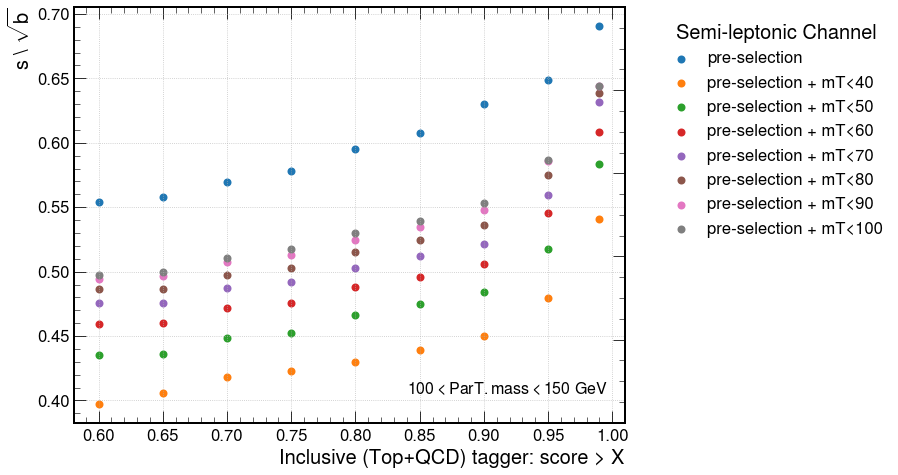

In [63]:
plt.rcParams.update({"font.size": 20})
channels = ["mu", "ele"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]
for mT_cut in mT_cuts:
    if mT_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mT<{mT_cut}"

    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            regressed_mass = df["fj_ParT_mass"]
            mass_window = (regressed_mass>100) & (regressed_mass<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$100<ParT.mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


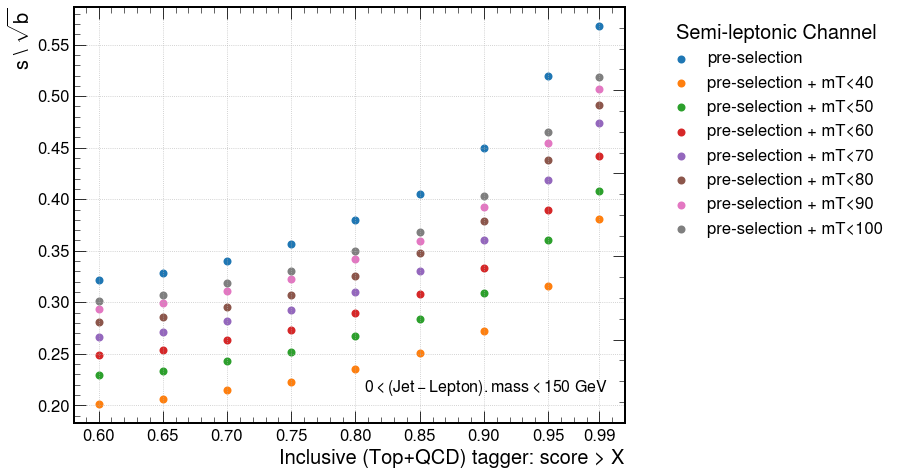

In [64]:
plt.rcParams.update({"font.size": 20})
channels = ["mu", "ele"]

fig, ax = plt.subplots(figsize=(13,7))
ax.grid()    

mT_cuts = [999999, 40, 50, 60, 70, 80, 90, 100]
for mT_cut in mT_cuts:
    if mT_cut==999999:
        cut_label = "pre-selection"
    else:
        cut_label = f"pre-selection + mT<{mT_cut}"
  
    tagger_cuts = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

    s = [0]*len(tagger_cuts)
    b = [0]*len(tagger_cuts)

    for ch in channels:
        for sample in events_dict[ch]:
            
            df = events_dict[ch][sample]
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
                        
            ev_weight = df["event_weight"]
            score = df["inclusive"]

            fj_minus_lep_mass = df["fj_minus_lep_mass"]
            mass_window = (fj_minus_lep_mass>0) & (fj_minus_lep_mass<150)

            for i, tagger_cut in enumerate(tagger_cuts):
                score_cut = (score > tagger_cut)
                if sample in signals:
                    s[i] += ev_weight[mass_window & score_cut].sum()     
                else:
                    b[i] += ev_weight[mass_window & score_cut].sum()

    ss = np.array(s)
    bb = np.array(b)
    ax.scatter(tagger_cuts, ss/np.sqrt(bb) , linewidth=2.0, label=cut_label)

ax.set_xticks(tagger_cuts)
ax.set_xlabel("Inclusive (Top+QCD) tagger: score > X")
ax.set_ylabel(r"s \ $\sqrt{b}$")
if len(channels)==2:
    ax.legend(title="Semi-leptonic Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);
else:
    ax.legend(title=f"{nice_channel[ch]} Channel", bbox_to_anchor=(1.05, 1), loc="upper left",);

ax2 = ax.twinx()
ax2.set_yticklabels([])
ax2.legend(title=r"$0<(Jet-Lepton).mass<150$ GeV", title_fontsize=16, loc=4)
plt.tight_layout()

# Stacked plots

In [65]:
# plot histograms
color_by_sample = {
    "HWW": "coral",
    "ttHToNonbb_M125": "tab:olive",
    "VH": "tab:brown",
    "VBF": "tab:gray",

    "DYJets": "tab:purple",
    "QCD": "tab:orange",
    "Diboson": "orchid",    
    "WJetsLNu": "tab:green",
    "TTbar": "tab:blue",
    "WZQQ": "salmon",
    "SingleTop": "tab:cyan",
    
    "WplusHToTauTau": "tab:cyan",
    "WminusHToTauTau": "tab:cyan",
    "ttHToTauTau": "tab:cyan",
    "GluGluHToTauTau": "tab:cyan",
    "ZHToTauTau": "tab:cyan",
    "VBFHToTauTau": "tab:cyan",
}

plot_labels = {
    "HWW": "ggH(WW)-Pt200",    
    "ttHToNonbb_M125": "ttH(WW)",
    "VH": "VH(WW)",
    "VBF": r"VBFH(WW) $(qq\ell\nu)$",
    
    "DYJets": r"Z$(\ell\ell)$+jets",    
    "QCD": "Multijet",
    "Diboson": "VV",
    "WJetsLNu": r"W$(\ell\nu)$+jets",
    "TTbar": r"$t\bar{t}$+jets",
    "WZQQ": r"W/Z$(qq)$",
    "SingleTop": r"Single Top",
    
    "WplusHToTauTau": "WplusHToTauTau",
    "WminusHToTauTau": "WminusHToTauTau",
    "ttHToTauTau": "ttHToTauTau",
    "GluGluHToTauTau": "GluGluHToTauTau",
    "ZHToTauTau": "ZHToTauTau",
    "VBFHToTauTau": "VBFHToTauTau"
}

label_by_ch = {
    "mu": "Muon",    
    "ele": "Electron",
}

signals = [
        "HWW",        
        "ttHToNonbb_M125",
        "VH",
        "VBF"]

In [66]:
def plot_hists(hists, vars_to_plot, logy, title_):

    add_data = False
    add_soverb = True
    only_sig = False

    # luminosity
    luminosity = 0
    for ch in channels:
        with open("../fileset/luminosity.json") as f:
            lum = json.load(f)[ch]["2017"]
            luminosity += lum / 1000.0
    luminosity = luminosity/2

    for var in vars_to_plot:
        if var not in hists.keys():
            print(f"{var} not stored in hists")
            continue

        print(f"Will plot {var} histogram")

        # get histograms
        h = hists[var]

        if (h.shape[0] == 0):  # skip empty histograms (such as lepton_pt for hadronic channel)
            print("Empty histogram ", var)
            continue

        # get samples existing in histogram
        samples = [h.axes[0].value(i) for i in range(len(h.axes[0].edges))]
        signal_labels = [label for label in samples if label in signals]
        bkg_labels = [
            label
            for label in samples
            if (label and label not in signal_labels)
        ]

        # get total yield of backgrounds per label
        # (sort by yield in fixed fj_pt histogram after pre-sel)        
        order_dic = {}
        for bkg_label in bkg_labels:
            if "fj_pt" in hists.keys():
                order_dic[plot_labels[bkg_label]] = hists["fj_pt"][{"samples": bkg_label}].sum()
            else:
                order_dic[plot_labels[bkg_label]] = hists[var][{"samples": bkg_label}].sum()

        # data
        data = None

        # signal
        signal = [h[{"samples": label}] for label in signal_labels]
        # scale signal for non-log plots
        if logy:
            mult_factor = 1
        else:
            mult_factor = 100
        signal_mult = [s * mult_factor for s in signal]

        # background
        bkg = [h[{"samples": label}] for label in bkg_labels]

        if add_data and data and len(bkg) > 0:
            if add_soverb and len(signal) > 0:
                fig, (ax, rax, sax) = plt.subplots(
                    nrows=3,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1, 1), "hspace": 0.07},
                    sharex=True,
                )
            else:
                fig, (ax, rax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                sax = None
        else:
            if add_soverb and len(signal) > 0:
                fig, (ax, sax) = plt.subplots(
                    nrows=2,
                    ncols=1,
                    figsize=(8, 8),
                    gridspec_kw={"height_ratios": (4, 1), "hspace": 0.07},
                    sharex=True,
                )
                rax = None
            else:
    #                 fig, ax = plt.subplots(1, 1)
                fig, ax = plt.subplots(figsize=(8,8))                
                rax = None
                sax = None

        errps = {
            "hatch": "////",
            "facecolor": "none",
            "lw": 0,
            "color": "k",
            "edgecolor": (0, 0, 0, 0.5),
            "linewidth": 0,
            "alpha": 0.4,
        }

        # sum all of the background
        if len(bkg) > 0:
            tot = bkg[0].copy()
            for i, b in enumerate(bkg):
                if i > 0:
                    tot = tot + b

            tot_val = tot.values()
            tot_val_zero_mask = tot_val == 0
            tot_val[tot_val_zero_mask] = 1

            tot_err = np.sqrt(tot_val)
            tot_err[tot_val_zero_mask] = 0

            # print(f'Background yield: ',tot_val,np.sum(tot_val))

        if add_data and data:
            data_err_opts = {
                "linestyle": "none",
                "marker": ".",
                "markersize": 10.0,
                "elinewidth": 1,
            }
            hep.histplot(
                data,
                ax=ax,
                histtype="errorbar",
                color="k",
                capsize=4,
                yerr=True,
                label=data_label,
                **data_err_opts,
            )

            if len(bkg) > 0:
                from hist.intervals import ratio_uncertainty

                data_val = data.values()
                data_val[tot_val_zero_mask] = 1

                yerr = ratio_uncertainty(data_val, tot_val, "poisson")

                hep.histplot(
                    data_val / tot_val,
                    tot.axes[0].edges,
                    # yerr=np.sqrt(data_val) / tot_val,
                    yerr=yerr,
                    ax=rax,
                    histtype="errorbar",
                    color="k",
                    capsize=4,
                )

                rax.axhline(1, ls="--", color="k")
                rax.set_ylim(0.2, 1.8)
                # rax.set_ylim(0.7, 1.3)

        # plot the background
        if len(bkg) > 0 and not only_sig:
            hep.histplot(
                bkg,
                ax=ax,
                stack=True,
                sort="yield",
                edgecolor="black",
                linewidth=1,
                histtype="fill",
                label=[plot_labels[bkg_label] for bkg_label in bkg_labels],
                color=[color_by_sample[bkg_label] for bkg_label in bkg_labels],
            )
            ax.stairs(
                values=tot.values() + tot_err,
                baseline=tot.values() - tot_err,
                edges=tot.axes[0].edges,
                **errps,
                label="Stat. unc.",
            )

        # plot the signal (times 10)
        if len(signal) > 0:
            tot_signal = None
            for i, sig in enumerate(signal_mult):
                lab_sig_mult = f"{mult_factor} * {plot_labels[signal_labels[i]]}"
                if mult_factor == 1:
                    lab_sig_mult = f"{plot_labels[signal_labels[i]]}"
                hep.histplot(
                    sig,
                    ax=ax,
                    label=lab_sig_mult,
                    linewidth=3,
                    color=color_by_sample[signal_labels[i]],
                )

                if tot_signal == None:
                    tot_signal = signal[i].copy()
                else:
                    tot_signal = tot_signal + signal[i]

            # plot the total signal (w/o scaling)
            hep.histplot(
                tot_signal, ax=ax, label=f"ggF+VBF+VH+ttH", linewidth=3, color="tab:red"
            )
            # add MC stat errors
            ax.stairs(
                values=tot_signal.values() + np.sqrt(tot_signal.values()),
                baseline=tot_signal.values() - np.sqrt(tot_signal.values()),
                edges=sig.axes[0].edges,
                **errps,
            )

            if sax is not None:
                totsignal_val = tot_signal.values()
                # replace values where bkg is 0
                totsignal_val[tot_val == 0] = 0
                soverb_val = totsignal_val / np.sqrt(tot_val)
                hep.histplot(
                    soverb_val,
                    tot_signal.axes[0].edges,
                    label="Total Signal",
                    ax=sax,
                    linewidth=3,
                    color="tab:red",
                )

                # integrate soverb in a given range for lep_fj_m (which, intentionally, is the first variable we pass)
                if var == "fj_minus_lep_mass":
                    bin_array = tot_signal.axes[0].edges[
                        :-1
                    ]  # remove last element since bins have one extra element
                    range_max = 150
                    range_min = 0

                    condition = (bin_array >= range_min) & (bin_array <= range_max)

                    s = totsignal_val[
                        condition
                    ].sum()  # sum/integrate signal counts in the range
                    b = np.sqrt(
                        tot_val[condition].sum()
                    )  # sum/integrate bkg counts in the range and take sqrt

                    soverb_integrated = round((s / b).item(), 2)
                    sax.legend(title=f"S/sqrt(B) (in 0-150)={soverb_integrated}")

        ax.set_ylabel("Events")
        if sax is not None:
            ax.set_xlabel("")
            if rax is not None:
                rax.set_xlabel("")
                rax.set_ylabel("Data/MC", fontsize=20)
            sax.set_ylabel(r"S/$\sqrt{B}$", fontsize=20)
    #             sax.set_xlabel(f"{utils.axis_dict[var].label}")
            sax.set_xlabel(f"{h.axes[-1].label}")   # assumes the variable to be plotted is at the last axis

        elif rax is not None:
            ax.set_xlabel("")
    #             rax.set_xlabel(f"{utils.axis_dict[var].label}")
            rax.set_xlabel(f"{h.axes[-1].label}")    # assumes the variable to be plotted is at the last axis

            rax.set_ylabel("Data/MC", fontsize=20)

        # get handles and labels of legend
        handles, labels = ax.get_legend_handles_labels()

        # append legend labels in order to a list
        summ = []
        for label in labels[: len(bkg_labels)]:
            summ.append(order_dic[label])
        # get indices of labels arranged by yield
        order = []
        for i in range(len(summ)):
            order.append(np.argmax(np.array(summ)))
            summ[np.argmax(np.array(summ))] = -100

        # plot data first, then bkg, then signal
        hand = [handles[-1]] + [handles[i] for i in order] + handles[len(bkg) : -1]
        lab = [labels[-1]] + [labels[i] for i in order] + labels[len(bkg) : -1]

        ax.legend(
            [hand[idx] for idx in range(len(hand))],
            [lab[idx] for idx in range(len(lab))],
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
            title=f"Semi-Leptonic Channel",
        )

        if logy:
            ax.set_yscale("log")
            ax.set_ylim(1e-1)

            hep.cms.lumitext(
                "%.1f " % luminosity + r"fb$^{-1}$ (13 TeV)", ax=ax, fontsize=20
            )
        hep.cms.text("Work in Progress", ax=ax, fontsize=15)

        ax2 = ax.twinx()
        ax2.set_yticklabels([])
        ax2.legend(title=title_, title_fontsize=20, loc=1)

In [153]:
channels = ["mu", "ele"]
### get samples_to_plot
samples_to_plot = list(events_dict[ch])

mT_cut = 100

# fill histograms
hists = {}
for var in ["fj_pt", "fj_minus_lep_mass", "lep_fj_dr"]:#, "fj_ParT_mass"]:
    if var == "fj_ParT_mass":
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            hist2.axis.Regular(30, 0, 260, name="var", label=r"fj_ParT_mass [GeV]", overflow=True)
        )
    else:
        hists[var] = hist2.Hist(
            hist2.axis.StrCategory([], name="samples", growth=True),
            utils.axis_dict[var],
        )
        
    for sample in samples_to_plot:
        
        for ch in channels:
            
            df = events_dict[ch][sample]

#             keep = ( df["lep_fj_dr"]>0.1 )
#             df = df.loc[keep, :]        
            
            ### apply mT cut
            keep = ( df["lep_met_mt"]<mT_cut )
            df = df.loc[keep, :]
      
            ### apply tagger cut
            keep = ( df["inclusive"]>0.9 )
            df = df.loc[keep, :]
            
            hists[var].fill(
                samples=sample,
                var=df[var],                
                weight=df["event_weight"]
                
            )

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Will plot fj_minus_lep_mass histogram


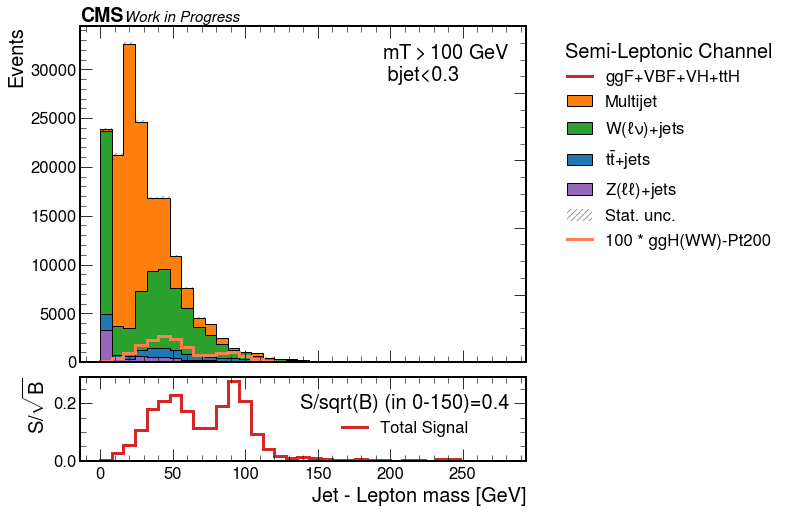

In [154]:
plot_hists(hists, ["fj_minus_lep_mass"], False, rf"$mT>{mT_cut}$ GeV" + "\n bjet<0.3")
# plot_hists(hists, ["fj_minus_lep_mass"], False, rf"$mT>{mT_cut}$ GeV" + "\n tagger>0.9")
# plot_hists(hists, ["lep_fj_dr"], False, rf"$mT<{mT_cut}$ GeV" + "\n tagger>0.9" + "\n bjet<0.3")
# plot_hists(hists, ["lep_fj_dr"], False, "")